# Working with vector data

**Author**: Andrea Ballatore (Birkbeck, University of London)

**Abstract**: Learn how to load, process, and save geospatial vector data using various formats with package _geopandas_.

**Credits**: Some examples adapted from 
 - https://github.com/jorisvandenbossche/geopandas-tutorial 
 - https://automating-gis-processes.github.io/site/notebooks/L2/projections.html

## Setup
This is to check that your environment is set up correctly (it should print 'env ok', ignore warnings).

In [1]:
# Test geospatial libraries
# check environment
import os
print("Conda env:", os.environ['CONDA_DEFAULT_ENV'])
if os.environ['CONDA_DEFAULT_ENV'] != 'geoprogv1':
    raise Exception("Set the environment 'geoprogv1' on Anaconda. Current environment: " + os.environ['CONDA_DEFAULT_ENV'])

# spatial libraries 
import fiona as fi
import geopandas
import pandas as pd
import pysal as sal
import math
import geoplot
import numpy as np

# create output folder
if not os.path.exists('tmp'):
    os.makedirs('tmp')

print('env ok')

Conda env: geoprogv1
env ok


----
## Python packages for vector data

- Python does not have a single standard package that provides all functionality to work with vector data.
- As is often the case, in Python we use a **combination** of highly specialised packages to achieve a goal.
- `fiona`: this package reads and writes vector data in GeoJSON, Shapefile, and other formats (https://github.com/Toblerity/Fiona).
- `shapely`: this package is specialised in geometric operations (https://shapely.readthedocs.io).
- `geopandas`: this package extends `pandas` data frames to provide _geographic data frames_ that can represent geometries with attributes (https://geopandas.org).
- `geoplot`: this package supports different types of geovisualisation (https://residentmario.github.io/geoplot).
- `GDAL`: many packages in Python (and other languages) rely on this old and robust library that provides hundreds of geospatial functions, including vector and raster processing (https://gdal.org).
- In this notebook we will use primarily `geopandas` to load and interact with vector data.

## Formats for vector data

- The most famous format for vector data, the **shapefile**, is a legacy format with many limitations (see http://switchfromshapefile.org).
- Modern formats include 
  - **GeoJSON**: Text-based format. It only stores coordinates in WGS84.
  - **GeoPackage**: Database-based format. It stores multiple datasets in a single file.
  - **TopoJSON**: An extension to GeoJSON to encode topology: https://github.com/topojson/topojson.

## Loading vector data
- As an example of vector data, `data/natural_earth_world_boundaries_50m_2018.geojson` contains country borders from https://github.com/andrea-ballatore/open-geo-data-education. Let us use `geopandas` to load this file:

In [48]:
countries = geopandas.read_file("data/natural_earth_world_boundaries_50m_2018.geojson")
type(countries)

geopandas.geodataframe.GeoDataFrame

- This object is of type `GeoDataFrame`, which is a `pandas` data frame associated with geometries.
- Columns `iso_a2` and `iso_a3` contain the unique ISO codes of countries that can be used as IDs, while the other columns contain various attributes, such as the continent and World Bank regions to which a country belongs.
- It supports all functions of normal data frames:

In [49]:
# print summary information about the data frame
print(countries.info())

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 241 entries, 0 to 240
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   iso_a2     241 non-null    object  
 1   iso_a3     241 non-null    object  
 2   name       241 non-null    object  
 3   name_long  241 non-null    object  
 4   abbrev     241 non-null    object  
 5   type       241 non-null    object  
 6   continent  241 non-null    object  
 7   region_un  241 non-null    object  
 8   subregion  241 non-null    object  
 9   region_wb  241 non-null    object  
 10  un_a3      241 non-null    object  
 11  wb_a2      241 non-null    object  
 12  wb_a3      241 non-null    object  
 13  geometry   241 non-null    geometry
dtypes: geometry(1), object(13)
memory usage: 26.5+ KB
None


In [50]:
# number of rows 
print(len(countries.index))
# number of columns
print(len(countries.columns))

241
14


In [56]:
# column names
print(countries.columns)
# show first 5 rows to inspect the data
countries.head(5)

Index(['iso_a2', 'iso_a3', 'name', 'name_long', 'abbrev', 'type', 'continent',
       'region_un', 'subregion', 'region_wb', 'un_a3', 'wb_a2', 'wb_a3',
       'geometry'],
      dtype='object')


,iso_a2,iso_a3,name,name_long,abbrev,type,continent,region_un,subregion,region_wb,un_a3,wb_a2,wb_a3,geometry
0,ZW,ZWE,Zimbabwe,Zimbabwe,Zimb.,Sovereign country,Africa,Africa,Eastern Africa,Sub-Saharan Africa,716,ZW,ZWE,"MULTIPOLYGON (((31.28789 -22.40205, 31.19727 -..."
1,ZM,ZMB,Zambia,Zambia,Zambia,Sovereign country,Africa,Africa,Eastern Africa,Sub-Saharan Africa,894,ZM,ZMB,"MULTIPOLYGON (((30.39609 -15.64307, 30.25068 -..."
2,YE,YEM,Yemen,Yemen,Yem.,Sovereign country,Asia,Asia,Western Asia,Middle East & North Africa,887,RY,YEM,"MULTIPOLYGON (((53.08564 16.64839, 52.58145 16..."
3,VN,VNM,Vietnam,Vietnam,Viet.,Sovereign country,Asia,Asia,South-Eastern Asia,East Asia & Pacific,704,VN,VNM,"MULTIPOLYGON (((104.06396 10.39082, 104.08301 ..."
4,VE,VEN,Venezuela,Venezuela,Ven.,Sovereign country,South America,Americas,South America,Latin America & Caribbean,862,VE,VEN,"MULTIPOLYGON (((-60.82119 9.13838, -60.94141 9..."


- The `geometry` column contains the geometries for each row:

In [57]:
countries.geometry

0      MULTIPOLYGON (((31.28789 -22.40205, 31.19727 -...
1      MULTIPOLYGON (((30.39609 -15.64307, 30.25068 -...
2      MULTIPOLYGON (((53.08564 16.64839, 52.58145 16...
3      MULTIPOLYGON (((104.06396 10.39082, 104.08301 ...
4      MULTIPOLYGON (((-60.82119 9.13838, -60.94141 9...
                             ...                        
236    MULTIPOLYGON (((19.34238 41.86909, 19.34551 41...
237    MULTIPOLYGON (((66.52227 37.34849, 66.82773 37...
238    MULTIPOLYGON (((77.04863 35.10991, 77.00449 35...
239    MULTIPOLYGON (((-45.71777 -60.52090, -45.49971...
240    MULTIPOLYGON (((-63.12305 18.06895, -63.01118 ...
Name: geometry, Length: 241, dtype: geometry

- Let us use `.plot()` to see a basic visualisation of the geometries, without projecting them.

<AxesSubplot:>

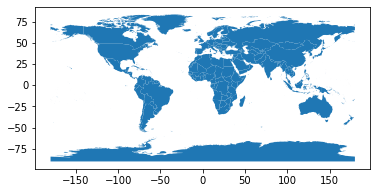

In [58]:
# plot geometries
countries.plot()

- As with normal data frames, it is possible to select a subset of data based on a **mask**, with the syntax `df[df['column_name']=='some value']`. This operation selects only the rows where this condition is true:

<AxesSubplot:>

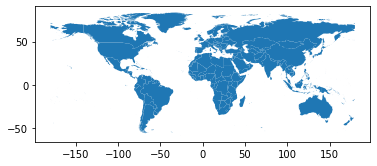

In [60]:
# remove Antarctica for visualisation (ISO code AQ)
countries = countries[countries.iso_a2 != 'AQ']
# plot geometries
countries.plot()

- We can select a subset of rows and plot them:

53


<AxesSubplot:>

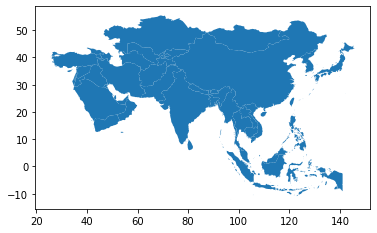

In [61]:
# select countries where continent is equal to 'Asia'
asian_countries = countries[countries['continent']=='Asia']
print(len(asian_countries.index))
asian_countries.plot()

- We can see the values contained in columns with `df.column_name.unique()`:

In [62]:
# UN regions
print(countries.region_un.unique())

['Africa' 'Asia' 'Americas' 'Europe' 'Oceania' 'Seven seas (open ocean)']


In [63]:
# World Bank regions
print(countries.region_wb.unique())

['Sub-Saharan Africa' 'Middle East & North Africa' 'East Asia & Pacific'
 'Latin America & Caribbean' 'Europe & Central Asia' 'North America'
 'Antarctica' 'South Asia']


## Projecting vector data

- These Python packages support CRS operations, such as projecting the data to a target CRS.
- CRS are usually referred using integer codes, which can be find on https://spatialreference.org or https://epsg.io. Common CRS include:
  - WGS84 (lon/lat): used in GPS https://epsg.io/4326
  - British National Grid (metres): used in the UK https://epsg.io/27700
  - UTM (for example zone 32N, metres): used globally (choose specific zone for your data) https://epsg.io/32632
  - Web Mercator: Spherical Mercator used in Google Maps, OpenStreetMap, Bing, ArcGIS, ESRI https://epsg.io/3857
- A couple of useful tools:
  - This tool helps you select an appropriate projection: http://projectionwizard.org
  - Tool that allows you to see a projection distortion: http://bl.ocks.org/syntagmatic/raw/ba569633d51ebec6ec6e

In [64]:
# print CRS of countries
countries.crs
# the data is in WGS84 (4326)

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

- Let us project the geometries representing Europe to different CRSs with `.to_crs(target_crs)`. See how the x and y coordinates change:

3035
3857
27700


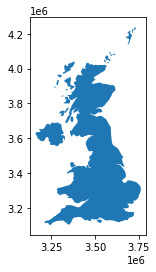

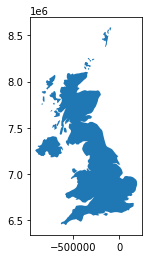

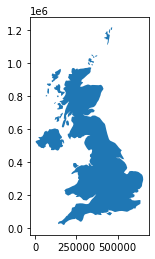

In [67]:
# select the UK (code: GB)
uk = countries[countries.iso_a2=='GB']

# project and plot for different CRSs
for target_crs in [3035, 3857, 27700]:
    print(target_crs)
    proj_uk = uk.to_crs(target_crs)
    proj_uk.plot()

- Let us reproject the world using well-known projections.
- See https://geopandas.org/projections.html for more details about projections in `geopandas`.
- Look those EPSG codes to find out what projections are the following ones:

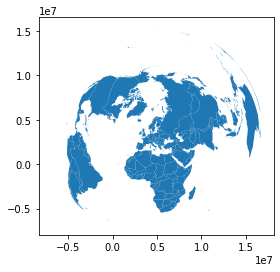

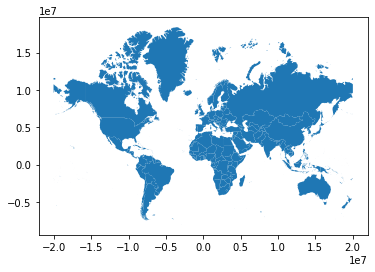

In [68]:
for target_crs in [3035,3857]:
    proj_countries = countries.to_crs(epsg=target_crs)
    proj_countries.plot()

- To draw world maps, let us project the countries to **Eckert IV**, an equal-area pseudocylindrical map projection that is suitable to represent the world without area distortion.
- As the projection is not direclty available in `geopandas`, let us import it from package `pyproj` using a string:

In [69]:
from pyproj import CRS
# Define projection Eckert IV from https://spatialreference.org/ref/esri/54012/
eckert_IV = CRS.from_proj4("+proj=eck4 +lon_0=0 +x_0=0 +y_0=0 +ellps=WGS84 +datum=WGS84 +units=m +no_defs")
eckert_IV

<Projected CRS: +proj=eck4 +lon_0=0 +x_0=0 +y_0=0 +ellps=WGS84 +da ...>
Name: unknown
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unknown
- method: Eckert IV
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

<AxesSubplot:>

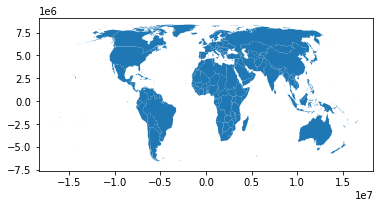

In [70]:
# project the countries
countries = countries.to_crs(eckert_IV)
countries.plot()

## Joining data frames

- In most data science work, we want to combine data from different tables, for example, associating attributes to geometries.
- The concept of **join** comes from relational databases, in which we combine two tables based on a shared **key** that links two pieces of information. For example, we might have socio-economic information about country "GB" and boundaries also linked to country "GB".

### Exploring input datasets
- The file `data/world_bank_indicators_2014_2019.tsv` contains several indicators from the World Bank at the country level (source: https://data.worldbank.org/indicator). 
- The data is relatively old but is very complete (more recent versions of this dataset have a lot of missing data).
- `NaN` in Python means `Not a number`. It is similar to `None` and in this case it just means that the value is not available.
- Let us explore this data frame:


In [72]:
# note that 'pd' is the abbreviation of pandas
wb_df = pd.read_csv('data/world_bank_indicators_2014_2019.tsv', sep='\t')
print(wb_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1584 entries, 0 to 1583
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   country_code       1584 non-null   object 
 1   gb_xpd_rsdv_gd_zs  575 non-null    float64
 2   iq_cpa_envr_xq     681 non-null    float64
 3   ms_mil_xpnd_gd_zs  1159 non-null   float64
 4   ny_gdp_mktp_cd     1486 non-null   float64
 5   ny_gdp_pcap_pp_cd  1427 non-null   float64
 6   ny_gnp_mktp_pp_cd  1418 non-null   float64
 7   sh_sta_airp_p5     229 non-null    float64
 8   sh_sta_mmrt_ne     301 non-null    float64
 9   sh_sta_traf_p5     219 non-null    float64
 10  sh_xpd_chex_gd_zs  1160 non-null   float64
 11  si_pov_dday        389 non-null    float64
 12  si_pov_mdim        190 non-null    float64
 13  si_pov_mdim_xq     33 non-null     float64
 14  sp_dyn_le00_in     1230 non-null   float64
 15  sp_dyn_tfrt_in     1231 non-null   float64
 16  sp_pop_0014_to_zs  1434 

In [74]:
# show 5 random rows with '.sample()'
wb_df.sample(5)

,country_code,gb_xpd_rsdv_gd_zs,iq_cpa_envr_xq,ms_mil_xpnd_gd_zs,ny_gdp_mktp_cd,ny_gdp_pcap_pp_cd,ny_gnp_mktp_pp_cd,sh_sta_airp_p5,sh_sta_mmrt_ne,sh_sta_traf_p5,sh_xpd_chex_gd_zs,si_pov_dday,si_pov_mdim,si_pov_mdim_xq,sp_dyn_le00_in,sp_dyn_tfrt_in,sp_pop_0014_to_zs,sp_pop_65up_to_zs,year
600,FCS,NaN,2.828125,1.670291,1.550707e+12,4618.340190,3.399175e+12,198.100615,NaN,25.257488,4.486906,36.8,NaN,NaN,60.888624,4.641525,41.395501,3.296098,2016
1472,MEX,NaN,NaN,0.516843,1.268871e+12,20582.386869,2.550276e+12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.185118,7.416661,2019
822,BTN,NaN,4.000000,NaN,2.450365e+09,11142.399948,7.585887e+09,NaN,NaN,NaN,3.244916,1.5,5.8,0.023,71.129000,1.994000,26.219381,5.924918,2017
297,CAN,1.69718,NaN,1.150126,1.556130e+12,44671.440681,1.570467e+12,NaN,6.0,NaN,10.683281,NaN,NaN,NaN,81.900000,1.563000,15.991481,16.053635,2015
129,LBR,NaN,3.000000,0.463083,3.144000e+09,1381.940254,5.386476e+09,NaN,NaN,NaN,9.062815,41.7,NaN,NaN,61.723000,4.621000,42.392097,3.197633,2014


- This is a rich dataset with many indicators. The full description of the indicators is in file `data/world_bank_indicators_dictionary.tsv`, which can be opened with Excel or similar programmes.
- We can join this data frame with the `countries` based on a common **key** `country_code` (the ISO 3-character country code).
- In `pandas`, the join operation is called _merge_ is called between two data frames: `df1.merge(df2, on='key')`.

### Checking the overlap of IDs
- Before calling a merge, we need to look at the keys to see whether they match in the two data frames.
- This can be done with a set theoretical operation to see which elements overlap between two sets: `set1.intersection(set2)`:

In [80]:
# set() creates a set from a list (removing duplicates):
print(set([1,2,2,3,4,5,5]))

{1, 2, 3, 4, 5}


In [78]:
# This is intersection:
set1 = set([1,2,3,4,5])
set2 = set([3,4,5,6,7])
print("set1", set1, "; set2", set2)

{1, 2, 3, 4, 5}
set1 {1, 2, 3, 4, 5} ; set2 {3, 4, 5, 6, 7}


In [79]:
print('overlap:', set1.intersection(set2))
print('difference:', set1.symmetric_difference(set2))

overlap: {3, 4, 5}
difference: {1, 2, 6, 7}


In [81]:
# let us compare the keys in the two data frames.
# note that some rows have "-99" as iso_a3 and can be discarded.
print("countries N:", len(set(countries.iso_a3)))
print("WB data N:", len(set(wb_df.country_code)))

countries N: 235
WB data N: 264


In [82]:
print("overlap:", len(set(countries.iso_a3).intersection(set(wb_df.country_code))))

overlap: 213


In [83]:
# These are all countries without data
print("difference:", set(countries.iso_a3).symmetric_difference(set(wb_df.country_code)))

difference: {'ARB', 'MSR', 'TSA', 'XKX', 'LAC', 'LIC', 'TSS', 'IOT', 'EAP', 'TEC', 'AIA', 'HMD', 'UMC', 'TUV', 'JEY', 'CSS', 'SSA', 'EAR', 'MNA', 'ESH', 'PSS', 'LMC', 'IDX', 'INX', '-99', 'HIC', 'PRE', 'SST', 'NAC', 'VAT', 'IBD', 'LDC', 'CHI', 'IDA', 'EAS', 'SPM', 'EUU', 'ECS', 'HPC', 'IBT', 'ALA', 'SHN', 'TMN', 'CEB', 'SAS', 'EMU', 'NFK', 'TLA', 'TEA', 'COK', 'SGS', 'LMY', 'PST', 'MIC', 'GGY', 'SSF', 'WLF', 'LCN', 'LTE', 'WLD', 'BLM', 'ATF', 'ECA', 'OSS', 'IDB', 'GIB', 'NIU', 'FLK', 'FCS', 'OED', 'MEA', 'TWN', 'PCN'}


- As the codes match, we can merge the two data frames knowing that the data is correct. As `wb_df` contains data about multiple years, we have to select data from specific years. 
- Let us consider per capita GDP in USD (`ny_gdp_pcap_pp_cd`) and military expenditure as % of GDP (`ms_mil_xpnd_gd_zs`):

### Merging data frames

In [1]:
# all country codes match! We can merge the two data frames 
# preserving all entries in the first data frame (how='left').

# Select data for 2019
df = wb_df[wb_df.year==2019]
# Select two indicators that are available for this year
df = df[['country_code','ny_gdp_pcap_pp_cd','ms_mil_xpnd_gd_zs']]

NameError: name 'wb_df' is not defined

In [85]:
wb_countries_2019 = countries.merge(df, left_on="iso_a3", right_on="country_code", how='left')

# explore content
wb_countries_2019.sample(4)

,iso_a2,iso_a3,name,name_long,abbrev,type,continent,region_un,subregion,region_wb,un_a3,wb_a2,wb_a3,geometry,country_code,ny_gdp_pcap_pp_cd,ms_mil_xpnd_gd_zs
130,XK,-99,Kosovo,Kosovo,Kos.,Sovereign country,Europe,Europe,Southern Europe,Europe & Central Asia,-099,KV,KSV,"MULTIPOLYGON (((1699610.124 5322121.120, 17097...",NaN,NaN,NaN
120,LT,LTU,Lithuania,Lithuania,Lith.,Sovereign country,Europe,Europe,Northern Europe,Europe & Central Asia,440,LT,LTU,"MULTIPOLYGON (((1604470.922 6578956.964, 15999...",LTU,38501.836436,2.026723
171,ET,ETH,Ethiopia,Ethiopia,Eth.,Sovereign country,Africa,Africa,Eastern Africa,Sub-Saharan Africa,231,ET,ETH,"MULTIPOLYGON (((3309392.017 723329.799, 330785...",ETH,2319.707378,0.601169
173,ER,ERI,Eritrea,Eritrea,Erit.,Sovereign country,Africa,Africa,Eastern Africa,Sub-Saharan Africa,232,ER,ERI,"MULTIPOLYGON (((3391179.088 1867653.412, 33864...",ERI,NaN,NaN


## Choropleth mapping

- With `geopandas` you can create a choropleth map with a single instruction.
- But, first, it is always important to see the distribution of a variable with a **histogram**.

array([<AxesSubplot:ylabel='Frequency'>], dtype=object)

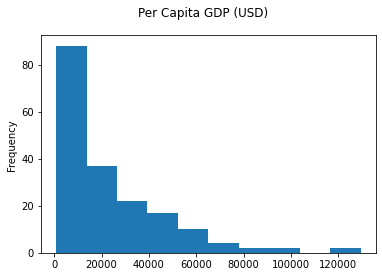

In [88]:
# explore the distribution of these variables first
wb_countries_2019.ny_gdp_pcap_pp_cd.plot(kind='hist',
    subplots=True, sharex=True, sharey=True, title='Per Capita GDP (USD)')

- This shows for example that most countries have a military expenditure between 1% and 2% of their GDP.

array([<AxesSubplot:ylabel='Frequency'>], dtype=object)

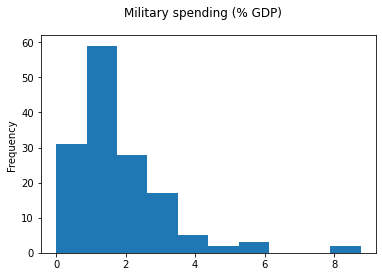

In [89]:
wb_countries_2019.ms_mil_xpnd_gd_zs.plot(kind='hist',
    subplots=True,sharex=True,sharey=True,title='Military spending (% GDP)')

- Let us generate a choropleth for per capita GDP. 
- Note the many parameters to `.plot(...)` that specify the column to plot, the colour scheme, the figure size, the aggregation scheme (quantiles), the number of bins (k), and the legend position:

240


<AxesSubplot:>

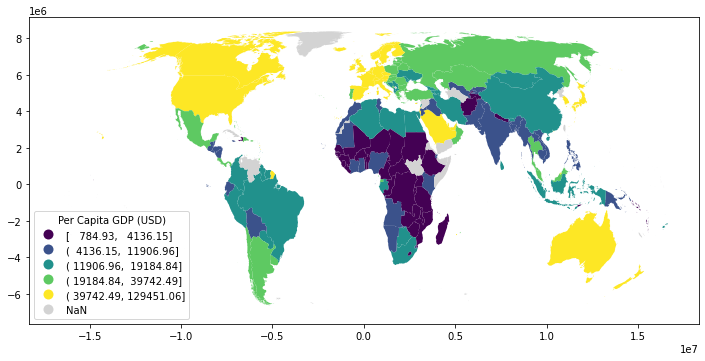

In [90]:
# copy data frame to df to keep the original data
df = wb_countries_2019.copy()

print(len(df))
# plot a column 
df.plot(column='ny_gdp_pcap_pp_cd', figsize=(12,9), scheme='quantiles', k=5, legend=True, 
    legend_kwds={'loc': 'lower left', 'title': 'Per Capita GDP (USD)'}, 
    missing_kwds = {'color': "lightgrey"})

<AxesSubplot:>

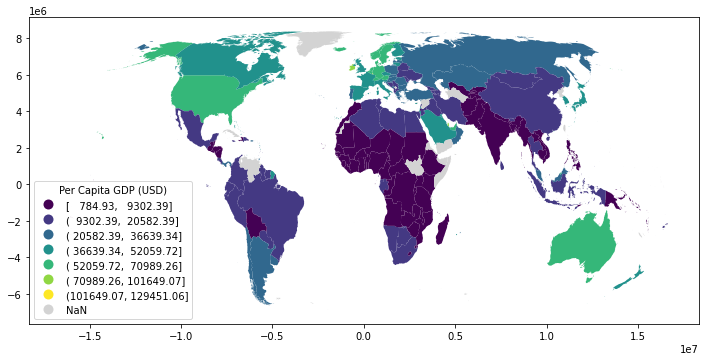

In [91]:
# plot the same data with different binning scheme (natural breaks) and more bins (7):
df.plot(column='ny_gdp_pcap_pp_cd', figsize=(12,9), scheme='NaturalBreaks', k=7, legend=True,   
    legend_kwds={'loc': 'lower left', 'title': 'Per Capita GDP (USD)'}, 
    missing_kwds = {'color': "lightgrey"})

<AxesSubplot:>

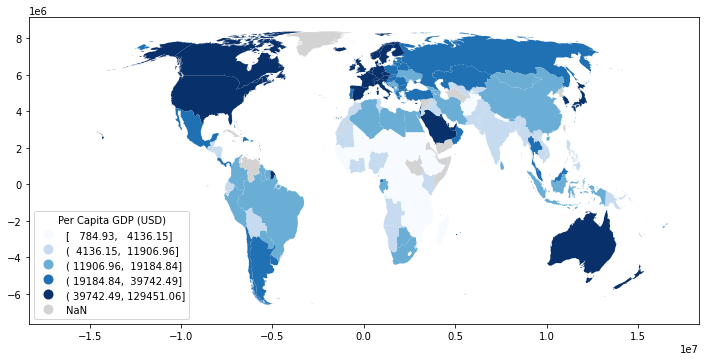

In [92]:
# plot the same data with different colours and reprojecting the boundaries:
df.plot(column='ny_gdp_pcap_pp_cd', figsize=(12,9), scheme='quantiles', cmap='Blues', k=5,
    legend=True, legend_kwds={'loc': 'lower left', 'title': 'Per Capita GDP (USD)'}, 
    missing_kwds = {'color': "lightgrey"})

## Saving maps to files

- The `cmap` (colour map) is rather standardised and you can find it at https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html
- When we want to export a figure from the notebook, we can save it as a file.
- Let us save a map of country-level per capita GDP in Africa:

In [93]:
import matplotlib.pyplot as plt

africa_df = wb_countries_2019[wb_countries_2019.continent=='Africa']
len(africa_df)

54

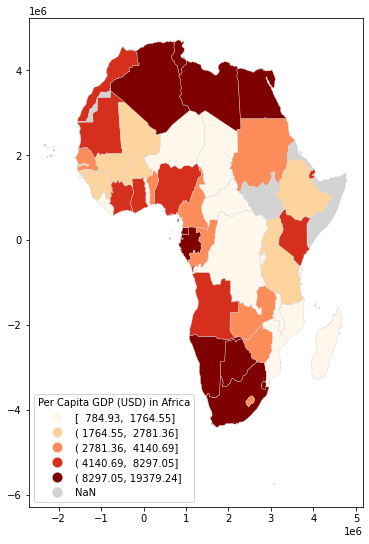

In [95]:
africa_df.plot(column='ny_gdp_pcap_pp_cd', figsize=(12,9), scheme='quantiles', cmap='OrRd', k=5,
    edgecolor="lightgrey", linewidth=0.4,
    legend=True, legend_kwds={'loc': 'lower left', 'title': 'Per Capita GDP (USD) in Africa'}, 
    missing_kwds = {'color': "lightgrey"})

plt.savefig('tmp/africa_gdp_2019_choro.pdf')
plt.savefig('tmp/africa_gdp_2019_choro.png')

- Now a file called `africa_gdp_2019_choro.pdf` has been created in folder `tmp`!
- Typically, we want to export visualisations as `PDF` to be able to edit them with tools like Adobe Illustrator or Inkscape. PDF is a vector format.
- If you want a simple image, you can export as `PNG`. PNG is a raster format.

## Bar charts
- To understand this data, we can create a **bar chart** too using package `seaborn` (https://seaborn.pydata.org/generated/seaborn.barplot.html):

## Using the Python `help` 

- To find out about the many and complicated parameters of `plot`, use `help()`:


In [21]:
help(df.plot)

Help on method plot in module geopandas.geodataframe:

plot(*args, **kwargs) method of geopandas.geodataframe.GeoDataFrame instance
    Plot a GeoDataFrame.
    
    Generate a plot of a GeoDataFrame with matplotlib.  If a
    column is specified, the plot coloring will be based on values
    in that column.
    
    Parameters
    ----------
    df : GeoDataFrame
        The GeoDataFrame to be plotted.  Currently Polygon,
        MultiPolygon, LineString, MultiLineString and Point
        geometries can be plotted.
    column : str, np.array, pd.Series (default None)
        The name of the dataframe column, np.array, or pd.Series to be plotted.
        If np.array or pd.Series are used then it must have same length as
        dataframe. Values are used to color the plot. Ignored if `color` is
        also set.
    cmap : str (default None)
        The name of a colormap recognized by matplotlib.
    color : str (default None)
        If specified, all objects will be colored uniforml

- Let us observe the other indicator at the global level:

In [96]:
df = wb_countries_2019
print(df.ms_mil_xpnd_gd_zs.describe())

# check top 10 countries for military expenditure as % of GDP (sort by
# military expenditure and get top 5 values)
df.sort_values('ms_mil_xpnd_gd_zs', ascending=False).head(5)

count    147.000000
mean       1.808828
std        1.375395
min        0.000000
25%        0.967855
50%        1.498323
75%        2.198014
max        8.761276
Name: ms_mil_xpnd_gd_zs, dtype: float64


,iso_a2,iso_a3,name,name_long,abbrev,type,continent,region_un,subregion,region_wb,un_a3,wb_a2,wb_a3,geometry,country_code,ny_gdp_pcap_pp_cd,ms_mil_xpnd_gd_zs
87,OM,OMN,Oman,Oman,Oman,Sovereign country,Asia,Asia,Western Asia,Middle East & North Africa,512,OM,OMN,"MULTIPOLYGON (((5383330.730 2631818.852, 53777...",OMN,28507.476217,8.761276
67,SA,SAU,Saudi Arabia,Saudi Arabia,Saud.,Sovereign country,Asia,Asia,Western Asia,Middle East & North Africa,682,SA,SAU,"MULTIPOLYGON (((3333382.468 3279679.152, 33309...",SAU,49040.342946,7.979833
235,DZ,DZA,Algeria,Algeria,Alg.,Sovereign country,Africa,Africa,Northern Africa,Middle East & North Africa,012,DZ,DZA,"MULTIPOLYGON (((739505.557 4662846.964, 741517...",DZA,12019.928356,6.009523
129,KW,KWT,Kuwait,Kuwait,Kwt.,Sovereign country,Asia,Asia,Western Asia,Middle East & North Africa,414,KW,KWT,"MULTIPOLYGON (((4296548.973 3799350.021, 42918...",KWT,52059.723315,5.615501
138,IL,ISR,Israel,Israel,Isr.,Country,Asia,Asia,Western Asia,Middle East & North Africa,376,IL,ISR,"MULTIPOLYGON (((3143260.670 4254555.281, 31425...",ISR,42146.147172,5.257651


- check bottom 5 countries for military expenditure as % of GDP (sort by military expenditure and get top 5 values):

In [97]:
df.sort_values('ms_mil_xpnd_gd_zs', ascending=True).head(5)

,iso_a2,iso_a3,name,name_long,abbrev,type,continent,region_un,subregion,region_wb,un_a3,wb_a2,wb_a3,geometry,country_code,ny_gdp_pcap_pp_cd,ms_mil_xpnd_gd_zs
190,CR,CRI,Costa Rica,Costa Rica,C.R.,Sovereign country,North America,Americas,Central America,Latin America & Caribbean,188,CR,CRI,"MULTIPOLYGON (((-7718329.566 1258862.737, -771...",CRI,20443.485685,0.000000
84,PA,PAN,Panama,Panama,Pan.,Sovereign country,North America,Americas,Central America,Latin America & Caribbean,591,PA,PAN,"MULTIPOLYGON (((-7240602.411 1138728.188, -724...",PAN,32850.819351,0.000000
145,IS,ISL,Iceland,Iceland,Iceland,Sovereign country,Europe,Europe,Northern Europe,Europe & Central Asia,352,IS,ISL,"MULTIPOLYGON (((-1071056.047 7485638.991, -106...",ISL,60061.377381,0.000000
148,HT,HTI,Haiti,Haiti,Haiti,Sovereign country,North America,Americas,Caribbean,Latin America & Caribbean,332,HT,HTI,"MULTIPOLYGON (((-6588529.208 2568260.663, -658...",HTI,3034.012110,0.001287
110,MU,MUS,Mauritius,Mauritius,Mus.,Sovereign country,Seven seas (open ocean),Africa,Eastern Africa,Sub-Saharan Africa,480,MU,MUS,"MULTIPOLYGON (((5281603.487 -2665556.193, 5269...",MUS,23882.354268,0.153188



- With a scatterplot, we can compare military expenditure and GDP per capita. This analysis can answer the question: _what is the relationship between wealth and military expenditure_?

Text(0, 0.5, 'Per capita GDP (USD)')

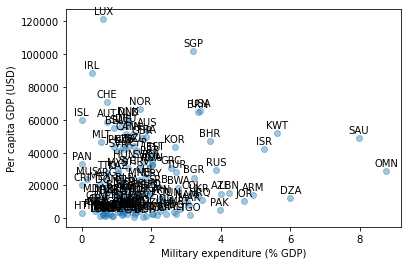

In [98]:
# simple scatter plot on variable x and y:
plt.scatter(df.ms_mil_xpnd_gd_zs, df.ny_gdp_pcap_pp_cd, alpha=0.4)

# iterate over the two variables (coordinates) and country names
for x,y,country in zip(df.ms_mil_xpnd_gd_zs, df.ny_gdp_pcap_pp_cd, df.country_code):
    plt.annotate(country, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,5), # distance from text to points (x,y)
                 ha='center')

# set x and y axis labels
plt.xlabel("Military expenditure (% GDP)")
plt.ylabel("Per capita GDP (USD)")

- This plot is too dense and is really hard to understand because of _occlusion_ (objects blocking the visibily of other objects).

## Using functions and for loops to visualise data

- Let us use a function to split this plot into a different plot for each continent.
- Note that this code allows you to generate multiple plots **without repeating any code**.
- You can see that in each continent some countries are particularly pacifist and other are more militaristic.

Africa


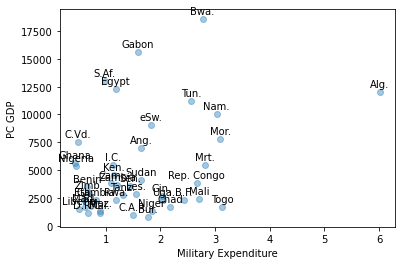

Asia


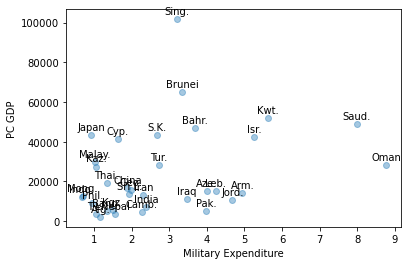

South America


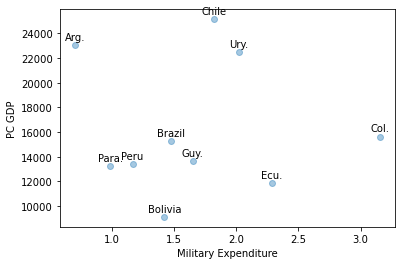

Europe


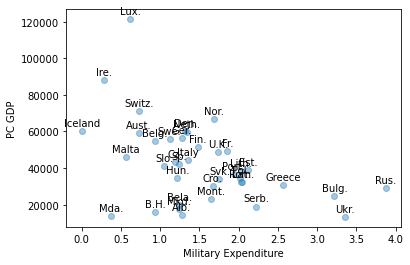

Oceania


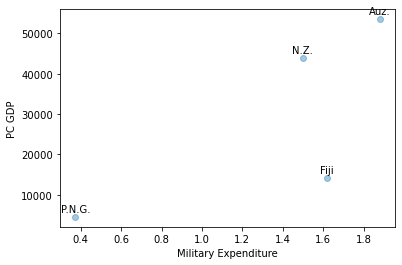

North America


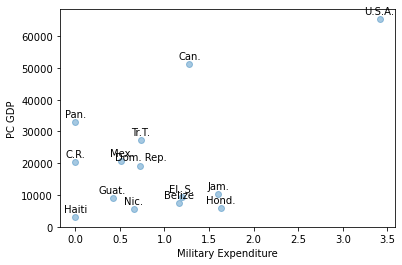

Seven seas (open ocean)


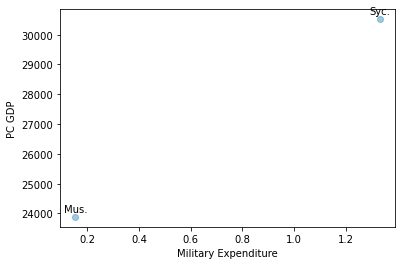

In [100]:
def plot_scatter_with_labels(df, varx, vary, varlab, labelx, labely):
    """It plots a scatterplot of two variables with labels and a choropleth:
    @ df: a data frame
    @ varx and vary: the columns to plot
    @ varlab: the column with labels
    @ labelx and labely: labels of x and y axes 
    """
    # simple scatter plot on variable x and y:
    plt.scatter(df[varx], df[vary], alpha=0.4)
    # iterate over the two variables (coordinates) and country names
    for x,y,lab in zip(df[varx], df[vary], df[varlab]):
        plt.annotate(lab, # this is the text
                    (x,y), # this is the point to label
                    textcoords="offset points", # how to position the text
                    xytext=(0,5), # distance from text to points (x,y)
                    ha='center')
    # set x and y axis labels
    plt.xlabel(labelx)
    plt.ylabel(labely)
    plt.show()

# iterate over continents and call a scatter plot for each continent
for continent in df.continent.unique():
    print(continent)
    cont_df = df[df.continent==continent]
    # call the function
    plot_scatter_with_labels(cont_df, 'ms_mil_xpnd_gd_zs', 'ny_gdp_pcap_pp_cd', 'abbrev', 'Mil Exp', 'PC GDP')

- To further explore this data, you can use the same approach to generate a different choropleth map for each continent:


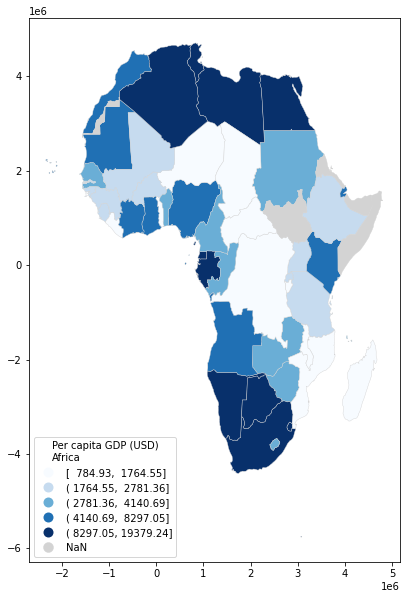

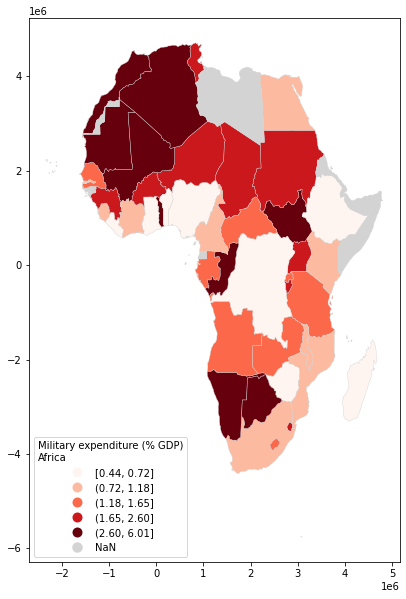

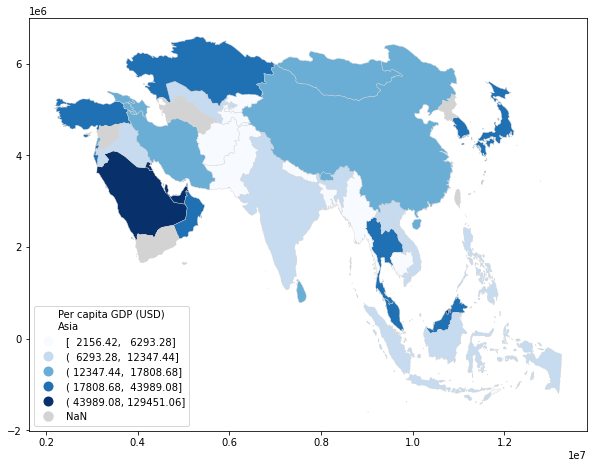

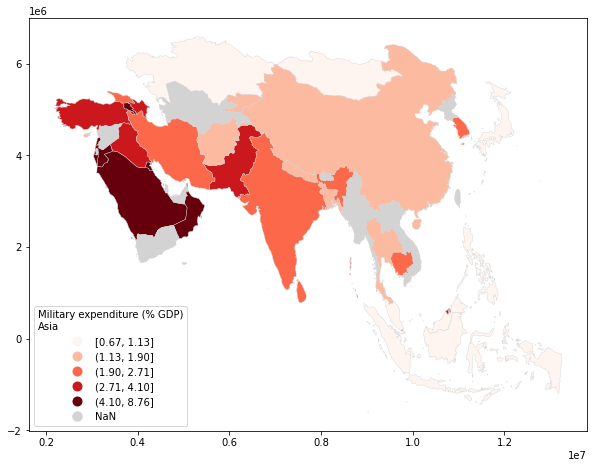

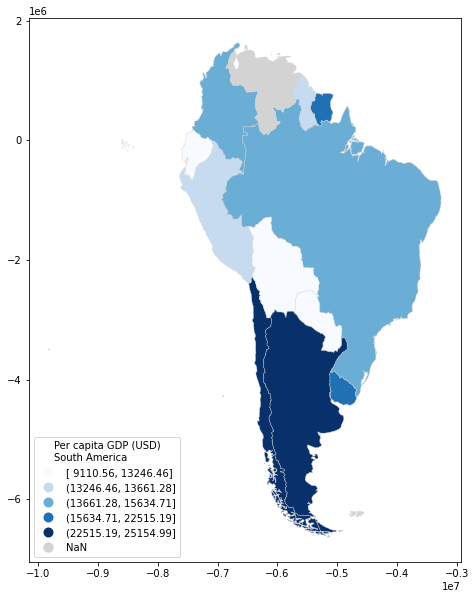

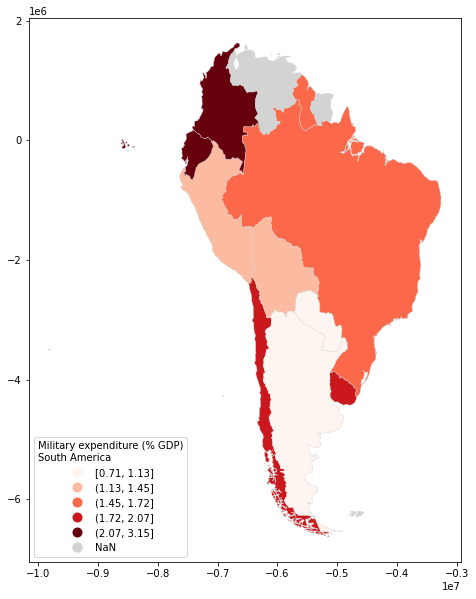

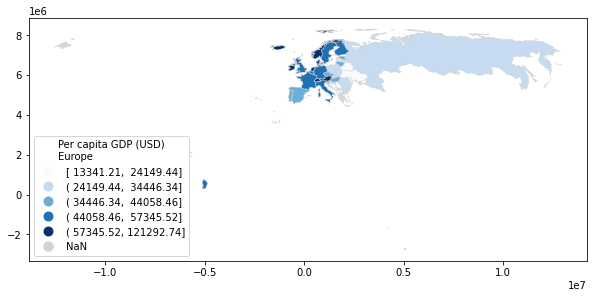

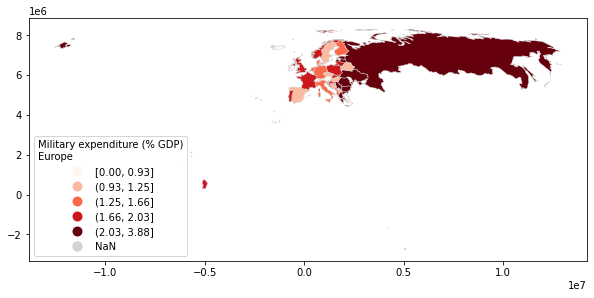

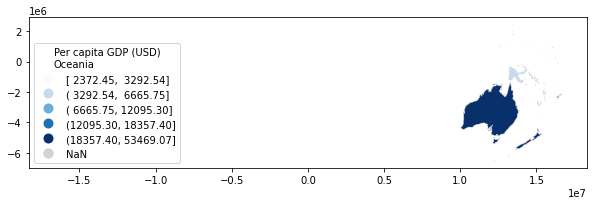

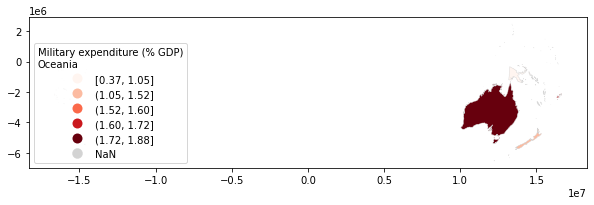

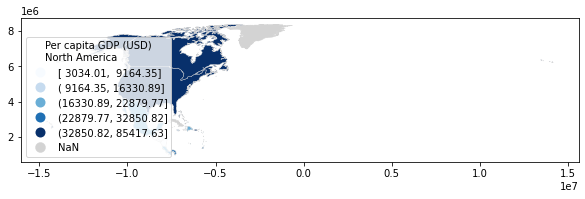

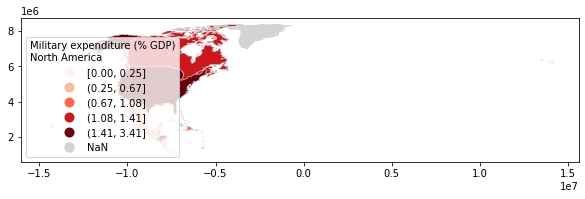

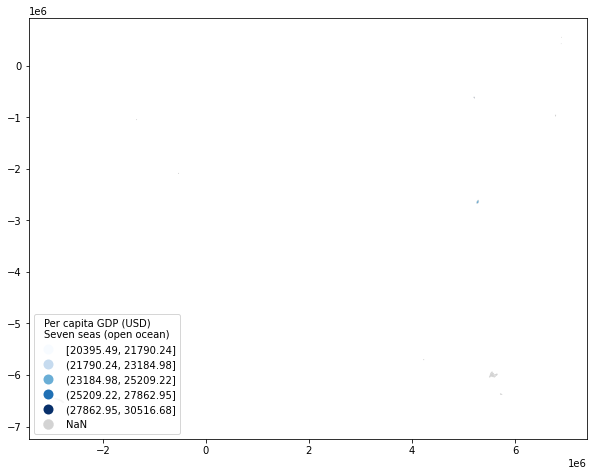

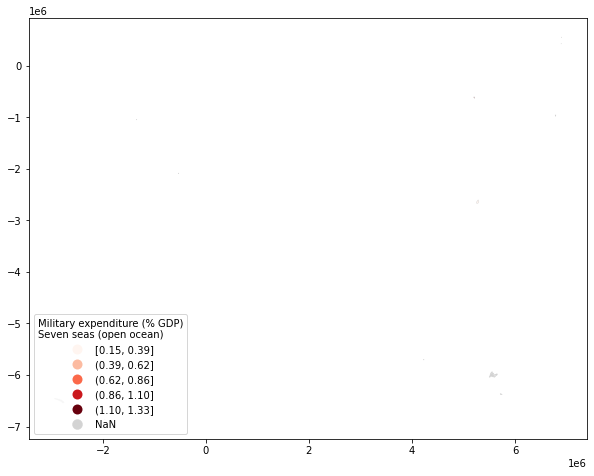

In [101]:
def plot_choropleth(df, var_name, legend_label, colors):
    """Plot choropleth on variable var_name from geodataframe df
    """
    # choropleth with reasonable default settings
    df.plot(column=var_name, scheme='Quantiles', k=5, legend=True, cmap=colors,
        edgecolor="lightgrey", linewidth=0.4,
        legend_kwds={'loc': 'lower left', 'title': legend_label},
        missing_kwds = {'color': "lightgrey"}, figsize=(10,10))
    # show result
    plt.show()

# iterate over continents and call a scatter plot for each continent
for continent in df.continent.unique():
    # select countries in a target continent
    cont_df = df[df.continent==continent]
    # call the function: note the legend label with the continent name
    plot_choropleth(cont_df, 'ny_gdp_pcap_pp_cd', 'Per capita GDP (USD)\n'+continent, 'Blues')
    plot_choropleth(cont_df, 'ms_mil_xpnd_gd_zs', 'Military expenditure (% GDP)\n'+continent, 'Reds')

- This kind of automation will save you a lot of time in generating analyses and visualisations!
- For more examples of visualisations, refer to https://residentmario.github.io/geoplot/gallery.

-----
## Geometric operations

- The Python packages we have been working with enable typical GIS operations on geometries.
- Let us start with **Set Operations** (https://geopandas.org/set_operations.html).
- For other operations, refer to https://geopandas.org/geometric_manipulations.html.
- This file contains the boundaries of European countries in **1914** from https://github.com/andrea-ballatore/open-geo-data-education:

In [102]:
import gzip
# note that we can read a gzipped (or zipped) file directly, 
# without having to extract it first:
europe14_df = geopandas.read_file( gzip.open('data/europe_boundaries_1914.geojson.gz','rb') )
print(europe14_df.info())

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 24 entries, 0 to 23
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   country_id    24 non-null     int64   
 1   country_name  24 non-null     object  
 2   geometry      24 non-null     geometry
dtypes: geometry(1), int64(1), object(1)
memory usage: 704.0+ bytes
None


In [103]:
print(europe14_df[['country_id','country_name']])

    country_id     country_name
0            1          Albania
1            2  Austria-Hungary
2            3          Belgium
3            4         Bulgaria
4            5          Denmark
5            6           France
6            7    German Empire
7            8           Greece
8            9            Italy
9           10    Liechtenstein
10          11       Luxembourg
11          12           Monaco
12          13       Montenegro
13          14      Netherlands
14          15           Norway
15          16         Portugal
16          17          Romania
17          18           Russia
18          19           Serbia
19          20            Spain
20          21           Sweden
21          22      Switzerland
22          23   Ottoman Empire
23          24   United Kingdom


<AxesSubplot:>

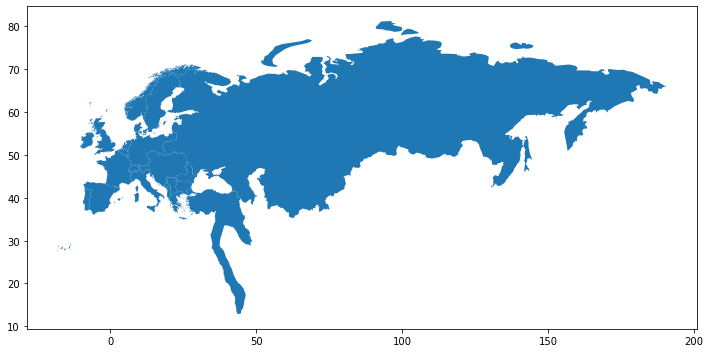

In [104]:
europe14_df.plot(figsize=(12,7))

- We can use **intersections** to see what are the spatial relations between political entities in 1914 and in 2018:

<AxesSubplot:>

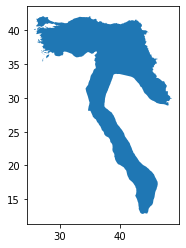

In [105]:
ottoman_empire_df = europe14_df[europe14_df.country_id==23]
ottoman_empire_df.plot()

- It is often useful to **overlay multiple datasets** in the same visualisation.
- In this case, we can overlay the borders of the Ottoman Empire in 1914 with the current country borders:

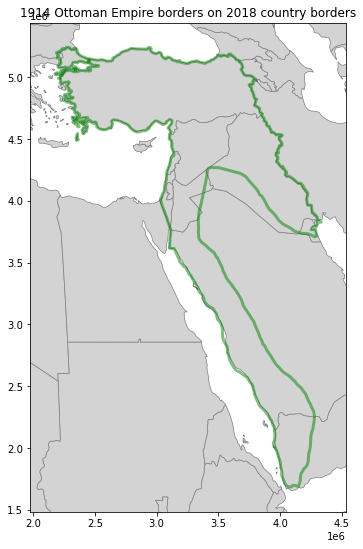

In [108]:
# define subplots: this tells Python that you want to plot multiple
# figures into one canvas.
# the object plt is also needed to control the process: 
import matplotlib.pyplot as plt

# set canvas
f, ax = plt.subplots(figsize=(14,9))
# project data
ottoman_empire_df_eck = ottoman_empire_df.to_crs(eckert_IV)
countries_df_eck = countries.to_crs(eckert_IV)

# plot first layer (countries in 2018, projected in eckert_IV)
countries_df_eck.plot(ax=ax, color='lightgray', edgecolor="gray", linewidth=.7)
# plot second layer (Ottoman Empire border)
ottoman_empire_df_eck.plot(ax=ax, facecolor="none", edgecolor="green", linewidth=3, alpha=.5)

# set map bounds
# offset for margin
buff = ottoman_empire_df_eck.buffer(200000)
xlim = ([buff.total_bounds[0], buff.total_bounds[2]])
ylim = ([buff.total_bounds[1], buff.total_bounds[3]])
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_title('1914 Ottoman Empire borders on 2018 country borders')

# show result
plt.show()

- With an **intersection**, we can see which areas belonged to the Ottoman Empire.
- We can calculate areas to see what percentage of a country belonged to the Ottoman Empire in 1914.
- It is important to bear in mind the potential inaccuracies of the data. Small differences might be due to inaccuracies in the borders and not to actual differences between the borders.

In [109]:
# make sure both datasets have the same projection
# eckert_IV that is suitable for large area calculations
ottoman_empire_df = ottoman_empire_df.to_crs(eckert_IV)
countries = countries.to_crs(eckert_IV)
# calculate full country area
countries['area_full'] = countries.area

In [112]:
# intersect the two data frames
countries2018 = geopandas.overlay(ottoman_empire_df, countries, how='intersection')
countries2018

,country_id,country_name,iso_a2,iso_a3,name,name_long,abbrev,type,continent,region_un,subregion,region_wb,un_a3,wb_a2,wb_a3,area_full,geometry
0,23,Ottoman Empire,YE,YEM,Yemen,Yemen,Yem.,Sovereign country,Asia,Asia,Western Asia,Middle East & North Africa,887,RY,YEM,4.551553e+11,"POLYGON ((4277750.121 2251155.819, 4276542.915..."
1,23,Ottoman Empire,TR,TUR,Turkey,Turkey,Tur.,Sovereign country,Asia,Asia,Western Asia,Europe & Central Asia,792,TR,TUR,7.815551e+11,"MULTIPOLYGON (((3110083.120 4545210.524, 31110..."
2,23,Ottoman Empire,SY,SYR,Syria,Syria,Syria,Sovereign country,Asia,Asia,Western Asia,Middle East & North Africa,760,SY,SYR,1.861561e+11,"POLYGON ((3136157.414 4395256.118, 3135079.157..."
3,23,Ottoman Empire,SA,SAU,Saudi Arabia,Saudi Arabia,Saud.,Sovereign country,Asia,Asia,Western Asia,Middle East & North Africa,682,SA,SAU,1.930155e+12,"MULTIPOLYGON (((3341637.637 3884453.838, 33394..."
4,23,Ottoman Empire,LB,LBN,Lebanon,Lebanon,Leb.,Sovereign country,Asia,Asia,Western Asia,Middle East & North Africa,422,LB,LBN,1.003399e+10,"POLYGON ((3098075.893 4273988.509, 3098649.647..."
5,23,Ottoman Empire,KW,KWT,Kuwait,Kuwait,Kwt.,Sovereign country,Asia,Asia,Western Asia,Middle East & North Africa,414,KW,KWT,1.736848e+10,"MULTIPOLYGON (((4301324.529 3811439.828, 42972..."
6,23,Ottoman Empire,JO,JOR,Jordan,Jordan,Jord.,Sovereign country,Asia,Asia,Western Asia,Middle East & North Africa,400,JO,JOR,8.905863e+10,"POLYGON ((3408802.274 4219677.682, 3406622.723..."
7,23,Ottoman Empire,IL,ISR,Israel,Israel,Isr.,Country,Asia,Asia,Western Asia,Middle East & North Africa,376,IL,ISR,2.233431e+10,"POLYGON ((3108391.902 3781825.588, 3104880.369..."
8,23,Ottoman Empire,PS,PSE,Palestine,Palestine,Pal.,Disputed,Asia,Asia,Western Asia,Middle East & North Africa,275,GZ,WBG,6.347502e+09,"MULTIPOLYGON (((3129255.956 4131817.024, 31331..."
9,23,Ottoman Empire,IQ,IRQ,Iraq,Iraq,Iraq,Sovereign country,Asia,Asia,Western Asia,Middle East & North Africa,368,IQ,IRQ,4.384357e+11,"POLYGON ((3856793.025 4684225.390, 3856360.736..."


<AxesSubplot:>

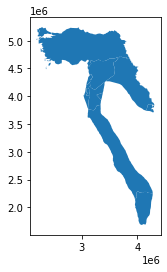

In [111]:
countries2018.plot()

In [115]:
# calculate area of intersection
countries2018['area_intersect'] = countries2018.area
# calculate percentage
countries2018['area_intersect_pc'] = round(countries2018.area_intersect / countries2018.area_full * 100,1)
# sort and select relevant columns
countries2018 = countries2018.sort_values('area_intersect_pc', ascending=False)
countries2018[['name','area_intersect','area_full','area_intersect_pc']]

,name,area_intersect,area_full,area_intersect_pc
2,Syria,1.860947e+11,1.861561e+11,100.0
1,Turkey,7.777417e+11,7.815551e+11,99.5
8,Palestine,6.215628e+09,6.347502e+09,97.9
7,Israel,2.149171e+10,2.233431e+10,96.2
4,Lebanon,9.433832e+09,1.003399e+10,94.0
6,Jordan,8.315542e+10,8.905863e+10,93.4
5,Kuwait,1.313037e+10,1.736848e+10,75.6
9,Iraq,3.307192e+11,4.384357e+11,75.4
0,Yemen,1.372714e+11,4.551553e+11,30.2
3,Saudi Arabia,4.813358e+11,1.930155e+12,24.9


- Finally, we can save the result of this calculation in a TSV file that we can open with Excel:

In [116]:
countries2018[['name','area_intersect','area_full','area_intersect_pc']].to_csv('tmp/ottoman_empire_countries_2018.tsv', sep='\t', index=False)

End of notebook